In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import os
import geopandas as gpd
from langchain_experimental.agents.agent_toolkits import (
    create_pandas_dataframe_agent,
)
from langchain_openai import OpenAI as OpenAI_langchain


client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)


df_community = pd.read_parquet("all_poster_commenter_details.parquet")
df_issues = pd.read_parquet("external_issue_details_with_posters_min.parquet")


def chat_response(content):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": content}],
    )
    return response.choices[0].message.content

In [77]:
df_issues

,title,body,createdAt,n_body_reactions_thumbs_up,n_body_reactions_thumbs_down,author.name,company
107,[FEA] Support casting operations on nested types,**Is your feature request related to a problem...,2021-01-27 14:31:06+00:00,0,0,Kuhu Shukla,None
108,[FEA] Support FIRST_VALUE and LAST_VALUE in gr...,**Is your feature request related to a problem...,2021-01-27 21:56:45+00:00,0,0,William Malpica,Voltron Data
117,[BUG] dask_cudf generates files it cannot read...,**Describe the bug**\r\n\r\nSomewhere between ...,2021-03-15 21:02:56+00:00,0,0,None,Graphistry
118,[FEA][INTERNALS] A `ColumnMeta` type to repres...,When we roundtrip a `Frame` between Python and...,2021-03-18 22:07:35+00:00,0,0,Ashwin Srinath,Voltron Data
120,[FEA] rolling correlation,**What is your question?**\r\nHow to calculate...,2021-03-22 14:11:38+00:00,0,0,None,None
...,...,...,...,...,...,...,...
854,[BUG] Data corruption and strange CUDA memory ...,**Describe the bug**\r\nWhenever I'm trying to...,2024-05-15 10:22:32+00:00,1,0,Taurean Dyer,None
858,[FEA] Potential optimization: Batched memset.,Under some situations in the Parquet reader (p...,2024-05-17 15:43:03+00:00,0,0,None,None
866,[ENH] Use `strict=True` argument to `zip` once...,In many places in the cudf code we zip two (or...,2024-05-23 09:59:08+00:00,0,0,Lawrence Mitchell,None
869,[FEA] Better control over the output dtype in ...,**Is your feature request related to a problem...,2024-05-24 13:37:43+00:00,0,0,Lawrence Mitchell,None


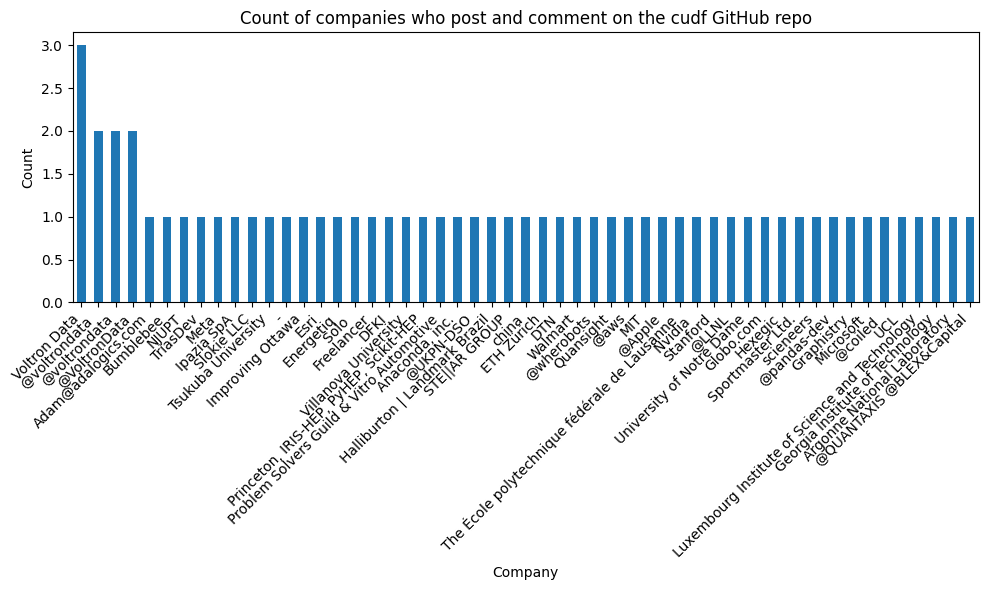

In [4]:
external_users = df_community[df_community["is_nvidia_employee"] == False]
company_counts = external_users['company'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

company_counts.plot(
    kind="bar",
    ax=ax,
    xlabel="Company",
    ylabel="Count",
    title="Count of companies who post and comment on the cudf GitHub repo",
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [6]:
chat_response("What type of company is Halliburton?")

'Halliburton is an American multinational corporation that provides services and products to the energy industry. They are primarily involved in providing services for oil and gas exploration, drilling, and production.'

In [ ]:
chat_response("What type of company is Wallmart?")

In [8]:
gdf_community = gpd.GeoDataFrame(
    df_community,
    geometry=gpd.points_from_xy(df_community["location_lon"], df_community["location_lat"]),
    crs="epsg:4326",
)

In [10]:
gdf_community[["login", "name", "followers", "company", "is_nvidia_employee", "geometry"]].explore(column="is_nvidia_employee", cmap="viridis", legend=True)

In [15]:
df_issues[df_issues["company"] == "Walmart"]["body"].values[0]

"having predicate pushdowns such as bloom filters work as in hive to skip over sections of data on disk during the read would enable better overall performance as the data would never have to be loaded to memory and then discarded if the predicate didn't match in the row group.\r\n\r\nsupport predicate pushdown similar to what is done with hive in read_orc, primary support for bloom filter but also for sorted data as well to enable only loading relevant data to query.\r\n\r\n\r\n"

In [36]:
content = (
    "Can you summarize this GitHub issue in the cudf repo? "
    f"{df_issues[df_issues['company'] == 'Walmart']['body'].values[0]}"
)
chat_response(content)

"The GitHub issue in the cudf repo discusses the potential benefits of implementing predicate pushdowns, specifically using bloom filters, similar to what is done in Hive. By implementing this feature, it would improve overall performance by skipping over sections of data on disk during reads, reducing the need to load unnecessary data into memory and then discarding it if the predicate doesn't match. The issue proposes adding support for predicate pushdowns in read_orc, focusing primarily on bloom filter support but also considering support for sorted data to only load relevant data for queries."

In [53]:
external_issues = df_issues[df_issues["is_nvidia_employee"] == False]
external_issues = external_issues.drop(columns=["is_nvidia_employee"])

In [54]:
from langchain_community.document_loaders.csv_loader import CSVLoader

In [75]:
loader = CSVLoader("external_issue_details_with_posters_min.csv")
data = loader.load()

In [59]:
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_csv_agent

In [68]:
df_issues["body"].values[-1]

'When converting floating point types to fixed point types, the casting operations are just blindly scaling the input values and then casting to integer without checking whether the scaled values are too big to be stored in the target integer types.\r\n\r\nProbably a more proper way to do casting here is to check for underflow/overflow and nullify the output accordingly.'

In [60]:
agent = create_csv_agent(
    OpenAI_langchain(temperature=0),
    "external_issue_details_with_posters_min.csv",
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

In [62]:
agent.run("how many rows are there?")

/Users/ray/miniforge3/envs/test_env/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens, however you requested 14638 tokens (14382 in your prompt; 256 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [61]:
agent

AgentExecutor(verbose=True, agent=RunnableAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_log_to_str(x['intermediate_steps']))
})
| PromptTemplate(input_variables=['agent_scratchpad', 'input'], partial_variables={'df_head': '|    |   Unnamed: 0 | title                                | body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [57]:
data

[Document(page_content=': 0\ntitle: Support for windows?\nbody: I use Linux at work but at home I have windows and would like to be able to run it on my main machine with conda. Currently when I run:\r\n\r\n`conda env create --name pygdf_dev --file conda_environments/testing_py35.yml`\r\n\r\nI am seeing this error:\r\n\r\n```\r\nNoPackagesFoundError: Package missing in current win-64 channels:\r\n  - libgdf_cffi >=0.1.0a1.dev\r\n```\r\n\r\nI am hoping that this could be easily added to the win-64 channels?\ncreatedAt: 2017-07-01T05:54:03Z\nn_body_reactions_thumbs_up: 43\nn_body_reactions_thumbs_down: 0\nauthor.name: stephenmm\ncompany: ', metadata={'source': 'external_issue_details_with_posters_min.csv', 'row': 0}),
 Document(page_content=': 2\ntitle: Add clang-tidy for automatic linting\nbody: <!--\r\n\r\nThanks for opening an issue! To help the libGDF team handle your information\r\nefficiently, please first ensure that there is no other issue present that\r\nalready describes the is

In [51]:
external_issues["body"].astype("string[pyarrow]")

0      I use Linux at work but at home I have windows...
2      <!--

Thanks for opening an issue! To help t...
3      **Describe the bug**

It takes a few seconds...
9      In Pandas, DatetimeIndexes can report back the...
11     Please add merge_asof to cudf to match pandas ...
                             ...                        
854    **Describe the bug**
Whenever I'm trying to u...
858    Under some situations in the Parquet reader (p...
866    In many places in the cudf code we zip two (or...
869    **Is your feature request related to a problem...
870    For the overload of replace in libcudf where i...
Name: body, Length: 381, dtype: string

In [79]:
external_issues.drop(columns="body")

,title,createdAt,n_body_reactions_thumbs_up,n_body_reactions_thumbs_down,author.name,company
0,Support for windows?,2017-07-01T05:54:03Z,43,0,stephenmm,None
2,Add clang-tidy for automatic linting,2018-08-29T18:00:18Z,0,0,Andrew Seidl,None
3,[BUG] Long import times,2019-01-04T02:46:53Z,0,0,Matthew Rocklin,@coiled
9,[FEA] DatetimeIndex Frequency/TZ,2019-06-06T16:09:44Z,0,0,Benjamin Zaitlen,None
11,[FEA]Add merge_asof to cudf,2019-07-12T17:04:59Z,0,0,None,None
...,...,...,...,...,...,...
854,[BUG] Data corruption and strange CUDA memory ...,2024-05-15T10:22:32Z,1,0,Taurean Dyer,None
858,[FEA] Potential optimization: Batched memset.,2024-05-17T15:43:03Z,0,0,None,None
866,[ENH] Use `strict=True` argument to `zip` once...,2024-05-23T09:59:08Z,0,0,Lawrence Mitchell,None
869,[FEA] Better control over the output dtype in ...,2024-05-24T13:37:43Z,0,0,Lawrence Mitchell,None


In [86]:
agent = create_pandas_dataframe_agent(
    OpenAI_langchain(temperature=0, model="gpt-3.5-turbo-instruct"),
    external_issues.drop(columns="body"),
)

In [87]:
agent.invoke("how many rows are there?")["output"]

'381'

In [88]:
agent.invoke("What issues are Walmart most interested in?")["output"]

'[FEA] predicate push down such as bloom filters added to read_orc'